## Isotope mass balance for hydrograph separation

### Wade Brook, 2022 ISCO dataset

#### Data are from the BREE OneDrive directory (Watershed Data>1_Projects>EMMA>Working file for MATLAB 2023/)

    For WB 2022 ISCO timeseries, 17 parameters total (including dD and d18O)

#### I didn't manipulate the csv in any way, just downloaded from the Sharepoint directory onto my machine. 

#### I also have the 2022 Wade potential endmember data (precipitation samples, and groundwater from well sampling).
 - No soil water for RI2022 dataset

#### I also brought in discharge data from https://uvmoffice-my.sharepoint.com/personal/sblocher_uvm_edu/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fsblocher%5Fuvm%5Fedu%2FDocuments%2FBREE%2FWatershed%20Data%2FStreams%2F02%5Fsite%5Fdata%2Fdischarge%2Fbest%5Fq

TO DO 

- [ ] save out new/old water in human and computer readable csv
- [ ] adaptive read-ins
- [ ] copy to wade notebook
- [ ] add in (scaled) s::can NO3 data

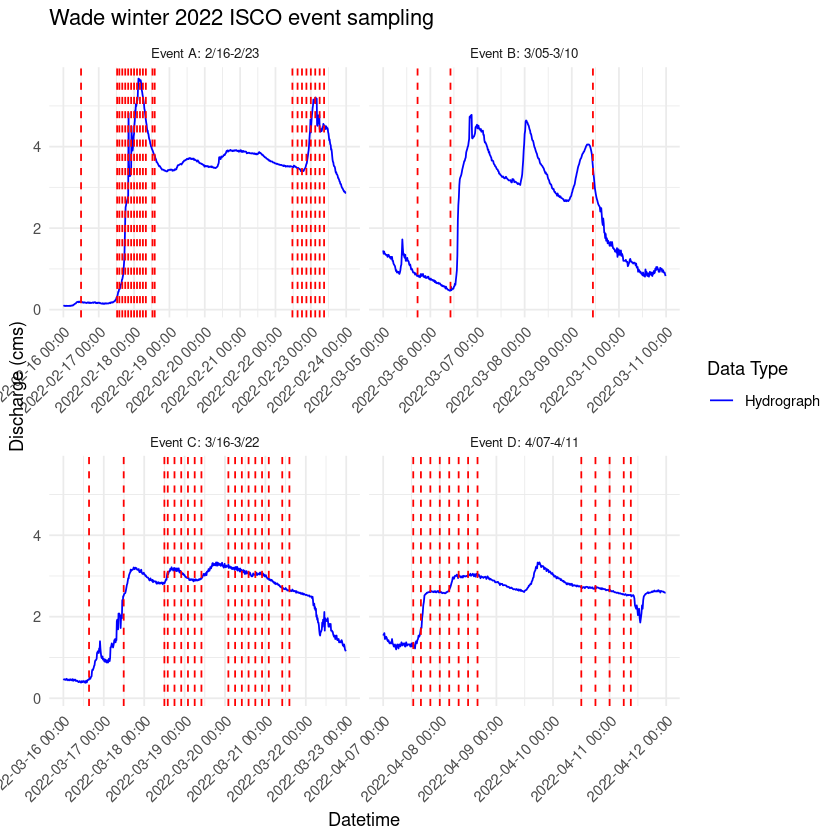

In [4]:
#################
# LOAD PACKAGES #
#################

library(tidyverse)
library(viridis)
library(dplyr)
library(lubridate)
library(caTools)  # for numerical integration
library(data.table) # for nearest join of q and ISCO data

###################
# SET DIRECTORIES #
###################

setwd("~//OneDrive/git-repos/cQ_analysis/")

input_dir <- "cond-hydrograph-separation/newrnet/data/"
output_dir <- "cond-hydrograph-separation/newrnet/output/"

#################
# SET SITE INFO #
#################

Site = "Wade"
Year = "winter 2022"

################
# READ IN DATA #
################

# read in the streamwater ISCO data
InputDataISCO <- read.csv(file.path(input_dir, "Data_for_EMMA_2022_timeseries_WB_MED.csv"))

# read in the potential endmember data
InputDataEM <- read.csv(file.path(input_dir, "end_members_2022_WB.csv"))

# read in the discharge data
InputDataQ <- read.csv(file.path(input_dir, "wade_2022_best_q_corr_MAT.csv")) %>%
    mutate(q_cms = best_q)

####################
# CLEAN THE DATA  #
####################

# Convert missing values to NA
InputDataISCO[InputDataISCO == ""] <- NA

# Combine 'Date' and 'Time' columns into 'Datetime' 
InputDataISCO$Datetime <- mdy_hm(paste(InputDataISCO$Date, InputDataISCO$Time))

# Assuming InputDataEM contains Date column in Date format
InputDataEM$Date <- as.Date(InputDataEM$Date, format = "%m/%d/%y")

# Convert 'timestamp' in InputDataQ to proper datetime format
InputDataQ$timestamp <- mdy_hm(InputDataQ$timestamp)

# Convert dataframes to data.table
InputDataISCO_DT <- as.data.table(InputDataISCO)
InputDataQ_DT <- as.data.table(InputDataQ)

# Set keys for joining
setkey(InputDataISCO_DT, Datetime)
setkey(InputDataQ_DT, timestamp)

###############
# JOIN Q DATA #
###############

# Perform a nearest join using data.table
merged_data <- InputDataQ_DT[InputDataISCO_DT, roll = "nearest", on = .(timestamp = Datetime)]

# Save the merged dataframe to a csv
write.csv(merged_data, file.path(output_dir, "merged_data.csv"), row.names = FALSE)

########################
# SEPARATE INTO EVENTS #
########################

# Make sure date formatting all good
merged_data$Date <- as.Date(merged_data$timestamp) # Assuming Datetime is in POSIXct format

# Add Event column based on date ranges
merged_data <- merged_data %>%
  mutate(Event = case_when(
    Date >= as.Date('2022-02-16') & Date <= as.Date('2022-02-23') ~ 'Event A: 2/16-2/23',
    Date >= as.Date('2022-03-05') & Date <= as.Date('2022-03-10') ~ 'Event B: 3/05-3/10',
    Date >= as.Date('2022-03-16') & Date <= as.Date('2022-03-22') ~ 'Event C: 3/16-3/22',
    Date >= as.Date('2022-04-07') & Date <= as.Date('2022-04-11') ~ 'Event D: 4/07-4/11',
    TRUE ~ NA_character_ # Assign NA to dates outside the defined ranges
  ))

# Doing the same as above for the original Q data
InputDataQ$Date <- as.Date(InputDataQ$timestamp)

# Add Event column based on date ranges
InputDataQ <- InputDataQ %>%
  mutate(Event = case_when(
    Date >= as.Date('2022-02-16') & Date <= as.Date('2022-02-23') ~ 'Event A: 2/16-2/23',
    Date >= as.Date('2022-03-05') & Date <= as.Date('2022-03-10') ~ 'Event B: 3/05-3/10',
    Date >= as.Date('2022-03-16') & Date <= as.Date('2022-03-22') ~ 'Event C: 3/16-3/22',
    Date >= as.Date('2022-04-07') & Date <= as.Date('2022-04-11') ~ 'Event D: 4/07-4/11',
    TRUE ~ NA_character_ # Assign NA to dates outside the defined ranges
  ))

# Filter out rows where Event is NA
InputDataQ <- InputDataQ %>%
  filter(!is.na(Event))

#######################
# PLOT THE HYDROGRAPH #
#######################

# include vertical lines for when we have ISCO samples
hydrograph_plot_InputDataQ_with_lines <- ggplot() +
  geom_line(data = InputDataQ, aes(x = timestamp, y = q_cms, color = "Hydrograph")) +
  geom_vline(data = InputDataISCO, aes(xintercept = Datetime), color = "red", linetype = "dashed") +
  theme_minimal() +
  labs(title = paste(Site, Year, "ISCO event sampling", sep = " "),
       x = "Datetime",
       y = "Discharge (cms)",
       color = "Data Type") +
  scale_x_datetime(date_labels = "%Y-%m-%d %H:%M", date_breaks = "1 day") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  facet_wrap(~ Event, scales = "free_x") +
  theme(strip.text = element_text(size = 8)) +
  scale_color_manual(values = c("Hydrograph" = "blue")) 

# Print the modified plot
print(hydrograph_plot_InputDataQ_with_lines)

# Save the plot to a file
ggsave(file.path(output_dir, "storm_hydrograph_ISCOs.png"), hydrograph_plot_InputDataQ_with_lines, width = 10, height = 6)

## 2 component isotope mass balance with d18O

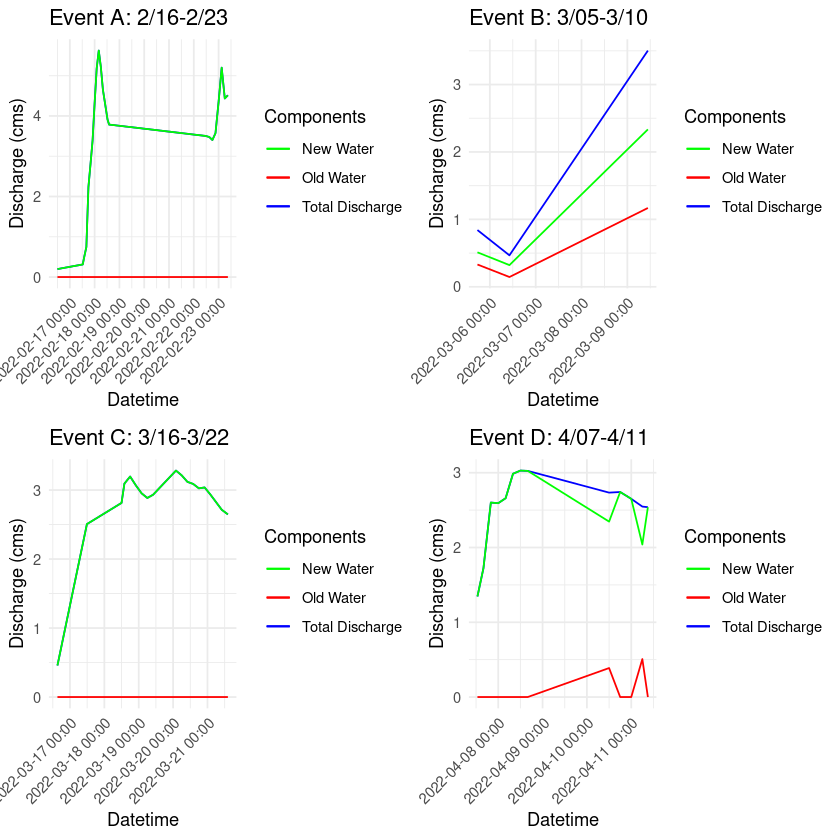

In [19]:
#############
# d18O IMB #
#############

# 2 components
# old water = groundwater
# new water = snowmelt lysimeter

#################
# LOAD PACKAGES #
#################

library(tidyverse)
library(viridis)
library(dplyr)
library(lubridate)
library(caTools)  # for numerical integration
library(data.table) # for nearest join of q and ISCO data
library(gridExtra) # for arranging ggplot objects in a grid

###################
# SET DIRECTORIES #
###################

setwd("~//OneDrive/git-repos/cQ_analysis/")

input_dir <- "cond-hydrograph-separation/newrnet/data/"
output_dir <- "cond-hydrograph-separation/newrnet/output/"

#################
# SET SITE INFO #
#################

Site = "Wade"
Year = "winter 2022"

################
# READ IN DATA #
################

# read in the streamwater ISCO data
InputDataISCO <- read.csv(file.path(input_dir, "Data_for_EMMA_2022_timeseries_WB_MED.csv"))

# read in the potential endmember data
InputDataEM <- read.csv(file.path(input_dir, "end_members_2022_WB.csv"))

# read in the discharge data
InputDataQ <- read.csv(file.path(input_dir, "wade_2022_best_q_corr_MAT.csv")) %>%
    mutate(q_cms = best_q)

####################
# CLEAN THE DATA  #
####################

# Convert missing values to NA
InputDataISCO[InputDataISCO == ""] <- NA

# Combine 'Date' and 'Time' columns into 'Datetime' 
InputDataISCO$Datetime <- mdy_hm(paste(InputDataISCO$Date, InputDataISCO$Time))

# Assuming InputDataEM contains Date column in Date format
InputDataEM$Date <- as.Date(InputDataEM$Date, format = "%m/%d/%y")

# Convert 'timestamp' in InputDataQ to proper datetime format
InputDataQ$timestamp <- mdy_hm(InputDataQ$timestamp)

# Convert dataframes to data.table
InputDataISCO_DT <- as.data.table(InputDataISCO)
InputDataQ_DT <- as.data.table(InputDataQ)

# Set keys for joining
setkey(InputDataISCO_DT, Datetime)
setkey(InputDataQ_DT, timestamp)

###############
# JOIN Q DATA #
###############

# Perform a nearest join using data.table
merged_data <- InputDataQ_DT[InputDataISCO_DT, roll = "nearest", on = .(timestamp = Datetime)]

# Save the merged dataframe to a csv
write.csv(merged_data, file.path(output_dir, "merged_data.csv"), row.names = FALSE)

########################
# SEPARATE INTO EVENTS #
########################

# Make sure date formatting all good
merged_data$Date <- as.Date(merged_data$timestamp) # Assuming Datetime is in POSIXct format

# Add Event column based on date ranges
merged_data <- merged_data %>%
  mutate(Event = case_when(
    Date >= as.Date('2022-02-16') & Date <= as.Date('2022-02-23') ~ 'Event A: 2/16-2/23',
    Date >= as.Date('2022-03-05') & Date <= as.Date('2022-03-10') ~ 'Event B: 3/05-3/10',
    Date >= as.Date('2022-03-16') & Date <= as.Date('2022-03-22') ~ 'Event C: 3/16-3/22',
    Date >= as.Date('2022-04-07') & Date <= as.Date('2022-04-11') ~ 'Event D: 4/07-4/11',
    TRUE ~ NA_character_ # Assign NA to dates outside the defined ranges
  ))

# Filter out rows where Event is NA
merged_data <- merged_data %>%
  filter(!is.na(Event))

# Nest data by Event
nested_data <- merged_data %>%
  group_by(Event) %>%
  nest()

# Create a function to calculate new and old water proportions and plot the hydrograph
process_event <- function(data, event_name, InputDataEM) {
  # Set new and old water values based on the event
  if (event_name == "Event A: 2/16-2/23") {
    Event_new <- -7.85 #InputDataEM %>%  #I am using the HB 2022-02-15 d18O SML because don't have one for Wade
      #filter(Type == "Snow" & Date == as.Date('2022-02-01')) %>%
      #pull(d18O)
    
    Event_old <- InputDataEM %>%
      filter(Type == "Groundwater" & Date == as.Date('2022-03-17') & Site == "Bear_Pond") %>%
      pull(d18O)
  } else if (event_name == "Event B: 3/05-3/10") {
    Event_new <- InputDataEM %>%
      filter(Type == "Snow lysimeter" & Date == as.Date('2022-03-04')) %>%
      pull(d18O)
    
    Event_old <- InputDataEM %>%
      filter(Type == "Groundwater" & Date == as.Date('2022-03-17') & Site == "Bear_Pond") %>%
      pull(d18O)
  } else if (event_name == "Event C: 3/16-3/22") {
    Event_new <- InputDataEM %>%
      filter(Type == "Snow lysimeter" & Date == as.Date('2022-03-17')) %>%
      pull(d18O)
    
    Event_old <- InputDataEM %>%
      filter(Type == "Groundwater" & Date == as.Date('2022-03-17') & Site == "Bear_Pond") %>%
      pull(d18O)
  } else if (event_name == "Event D: 4/07-4/11") {
    Event_new <- InputDataEM %>%
      filter(Type == "Snow lysimeter" & Date == as.Date('2022-03-17')) %>%
      pull(d18O)
    
    Event_old <- InputDataEM %>%
      filter(Type == "Groundwater" & Date == as.Date('2022-03-17') & Site == "Bear_Pond") %>%
      pull(d18O)
  } else {
    stop("Unknown event")
  }
  
  # Calculate Q_o(t) using Equation 3
  #data <- data %>%
    #mutate(Q_o = `q_cms` * (`d18O` - Event_new) / (Event_old - Event_new),
           #Q_n = `q_cms` - Q_o)
    
  # Calculate Q_o(t) using Equation 3 and ensure it is non-negative
  data <- data %>%
  mutate(Q_o = pmax(`q_cms` * (`d18O` - Event_new) / (Event_old - Event_new), 0),
         Q_n = pmax(`q_cms` - Q_o, 0))
  
  # Plot using ggplot2
  hydrograph_plot <- ggplot(data, aes(x = timestamp)) +
    geom_line(aes(y = q_cms, color = "Total Discharge")) +
    geom_line(aes(y = Q_o, color = "Old Water")) +
    geom_line(aes(y = Q_n, color = "New Water")) +
    scale_color_manual(values = c("Total Discharge" = "blue", "Old Water" = "red", "New Water" = "green")) +
    theme_minimal() +
    labs(title = event_name,
         x = "Datetime",
         y = "Discharge (cms)",
         color = "Components") +
    scale_x_datetime(date_labels = "%Y-%m-%d %H:%M", date_breaks = "1 day") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
  
  # Save the plot to a file
  ggsave(file.path(output_dir, paste0("storm_hydrograph_", gsub("[: ]", "_", event_name), ".png")), hydrograph_plot, width = 10, height = 6)
  
  return(hydrograph_plot)
}

# Apply the function to each event
plots <- nested_data %>%
  mutate(plot = map2(data, Event, ~ process_event(.x, .y, InputDataEM)))

# Print all plots 
# Uncomment to print single event plots
#plots$plot

# Arrange the plots in a 2x2 grid
grid.arrange(grobs = plots$plot, ncol = 2)

# Save the 2x2 grid plot
ggsave(file.path(output_dir, paste(Site, Year, "event_IHS_grid.png")), 
       arrangeGrob(grobs = plots$plot, ncol = 2), 
       width = 15, height = 10)

# DEUTERIUM

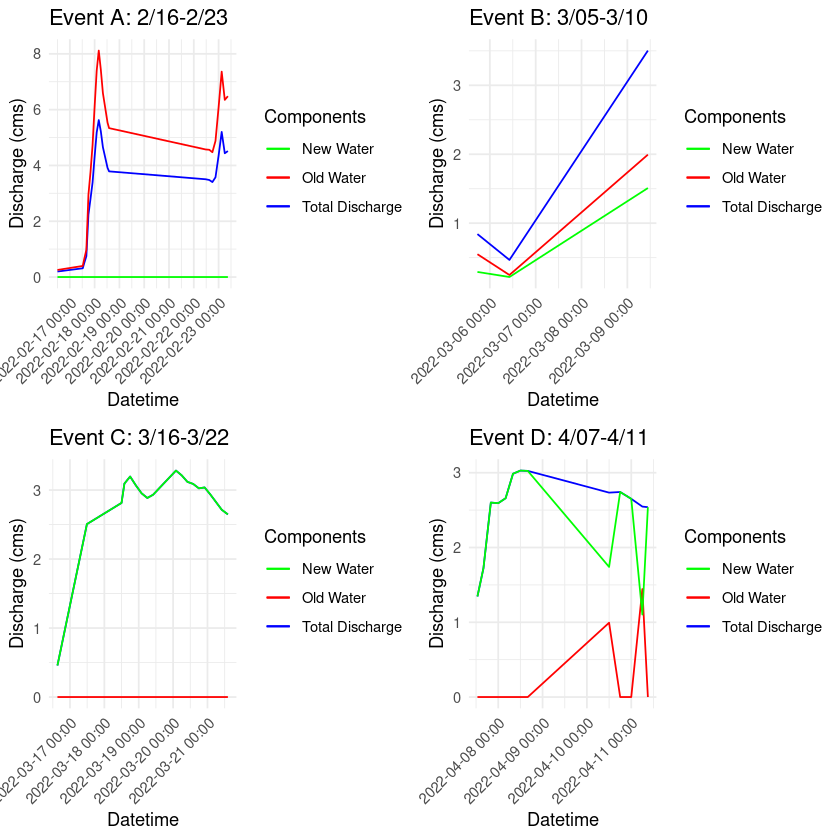

In [20]:
#############
# dD IMB #
#############

# 2 components
# old water = groundwater
# new water = snowmelt lysimeter

#################
# LOAD PACKAGES #
#################

library(tidyverse)
library(viridis)
library(dplyr)
library(lubridate)
library(caTools)  # for numerical integration
library(data.table) # for nearest join of q and ISCO data
library(gridExtra) # for arranging ggplot objects in a grid

###################
# SET DIRECTORIES #
###################

setwd("~//OneDrive/git-repos/cQ_analysis/")

input_dir <- "cond-hydrograph-separation/newrnet/data/"
output_dir <- "cond-hydrograph-separation/newrnet/output/"

#################
# SET SITE INFO #
#################

Site = "Wade"
Year = "winter 2022"

################
# READ IN DATA #
################

# read in the streamwater ISCO data
InputDataISCO <- read.csv(file.path(input_dir, "Data_for_EMMA_2022_timeseries_WB_MED.csv"))

# read in the potential endmember data
InputDataEM <- read.csv(file.path(input_dir, "end_members_2022_WB.csv"))

# read in the discharge data
InputDataQ <- read.csv(file.path(input_dir, "wade_2022_best_q_corr_MAT.csv")) %>%
    mutate(q_cms = best_q)

####################
# CLEAN THE DATA  #
####################

# Convert missing values to NA
InputDataISCO[InputDataISCO == ""] <- NA

# Combine 'Date' and 'Time' columns into 'Datetime' 
InputDataISCO$Datetime <- mdy_hm(paste(InputDataISCO$Date, InputDataISCO$Time))

# Assuming InputDataEM contains Date column in Date format
InputDataEM$Date <- as.Date(InputDataEM$Date, format = "%m/%d/%y")

# Convert 'timestamp' in InputDataQ to proper datetime format
InputDataQ$timestamp <- mdy_hm(InputDataQ$timestamp)

# Convert dataframes to data.table
InputDataISCO_DT <- as.data.table(InputDataISCO)
InputDataQ_DT <- as.data.table(InputDataQ)

# Set keys for joining
setkey(InputDataISCO_DT, Datetime)
setkey(InputDataQ_DT, timestamp)

###############
# JOIN Q DATA #
###############

# Perform a nearest join using data.table
merged_data <- InputDataQ_DT[InputDataISCO_DT, roll = "nearest", on = .(timestamp = Datetime)]

# Save the merged dataframe to a csv
write.csv(merged_data, file.path(output_dir, "merged_data.csv"), row.names = FALSE)

########################
# SEPARATE INTO EVENTS #
########################

# Make sure date formatting all good
merged_data$Date <- as.Date(merged_data$timestamp) # Assuming Datetime is in POSIXct format

# Add Event column based on date ranges
merged_data <- merged_data %>%
  mutate(Event = case_when(
    Date >= as.Date('2022-02-16') & Date <= as.Date('2022-02-23') ~ 'Event A: 2/16-2/23',
    Date >= as.Date('2022-03-05') & Date <= as.Date('2022-03-10') ~ 'Event B: 3/05-3/10',
    Date >= as.Date('2022-03-16') & Date <= as.Date('2022-03-22') ~ 'Event C: 3/16-3/22',
    Date >= as.Date('2022-04-07') & Date <= as.Date('2022-04-11') ~ 'Event D: 4/07-4/11',
    TRUE ~ NA_character_ # Assign NA to dates outside the defined ranges
  ))

# Filter out rows where Event is NA
merged_data <- merged_data %>%
  filter(!is.na(Event))

# Nest data by Event
nested_data <- merged_data %>%
  group_by(Event) %>%
  nest()

# Create a function to calculate new and old water proportions and plot the hydrograph
process_event <- function(data, event_name, InputDataEM) {
  # Set new and old water values based on the event
  if (event_name == "Event A: 2/16-2/23") {
    Event_new <- -7.85 #InputDataEM %>%  #I am using the HB 2022-02-15 dD SML because don't have one for Wade
      #filter(Type == "Snow" & Date == as.Date('2022-02-01')) %>%
      #pull(dD)
    
    Event_old <- InputDataEM %>%
      filter(Type == "Groundwater" & Date == as.Date('2022-03-17') & Site == "Bear_Pond") %>%
      pull(dD)
  } else if (event_name == "Event B: 3/05-3/10") {
    Event_new <- InputDataEM %>%
      filter(Type == "Snow lysimeter" & Date == as.Date('2022-03-04')) %>%
      pull(dD)
    
    Event_old <- InputDataEM %>%
      filter(Type == "Groundwater" & Date == as.Date('2022-03-17') & Site == "Bear_Pond") %>%
      pull(dD)
  } else if (event_name == "Event C: 3/16-3/22") {
    Event_new <- InputDataEM %>%
      filter(Type == "Snow lysimeter" & Date == as.Date('2022-03-17')) %>%
      pull(dD)
    
    Event_old <- InputDataEM %>%
      filter(Type == "Groundwater" & Date == as.Date('2022-03-17') & Site == "Bear_Pond") %>%
      pull(dD)
  } else if (event_name == "Event D: 4/07-4/11") {
    Event_new <- InputDataEM %>%
      filter(Type == "Snow lysimeter" & Date == as.Date('2022-03-17')) %>%
      pull(dD)
    
    Event_old <- InputDataEM %>%
      filter(Type == "Groundwater" & Date == as.Date('2022-03-17') & Site == "Bear_Pond") %>%
      pull(dD)
  } else {
    stop("Unknown event")
  }
  
  # Calculate Q_o(t) using Equation 3
  #data <- data %>%
    #mutate(Q_o = `q_cms` * (`dD` - Event_new) / (Event_old - Event_new),
           #Q_n = `q_cms` - Q_o)
    
  # Calculate Q_o(t) using Equation 3 and ensure it is non-negative
  data <- data %>%
  mutate(Q_o = pmax(`q_cms` * (`dD` - Event_new) / (Event_old - Event_new), 0),
         Q_n = pmax(`q_cms` - Q_o, 0))
  
  # Plot using ggplot2
  hydrograph_plot <- ggplot(data, aes(x = timestamp)) +
    geom_line(aes(y = q_cms, color = "Total Discharge")) +
    geom_line(aes(y = Q_o, color = "Old Water")) +
    geom_line(aes(y = Q_n, color = "New Water")) +
    scale_color_manual(values = c("Total Discharge" = "blue", "Old Water" = "red", "New Water" = "green")) +
    theme_minimal() +
    labs(title = event_name,
         x = "Datetime",
         y = "Discharge (cms)",
         color = "Components") +
    scale_x_datetime(date_labels = "%Y-%m-%d %H:%M", date_breaks = "1 day") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
  
  # Save the plot to a file
  ggsave(file.path(output_dir, paste0("storm_hydrograph_", gsub("[: ]", "_", event_name), ".png")), hydrograph_plot, width = 10, height = 6)
  
  return(hydrograph_plot)
}

# Apply the function to each event
plots <- nested_data %>%
  mutate(plot = map2(data, Event, ~ process_event(.x, .y, InputDataEM)))

# Print all plots 
# Uncomment to print single event plots
#plots$plot

# Arrange the plots in a 2x2 grid
grid.arrange(grobs = plots$plot, ncol = 2)

# Save the 2x2 grid plot
ggsave(file.path(output_dir, paste(Site, Year, "event_IHS_grid.png")), 
       arrangeGrob(grobs = plots$plot, ncol = 2), 
       width = 15, height = 10)